Library import

In [12]:
import shutil
import random
from pathlib import Path
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split

Data Prepare

In [13]:
source_dir = 'E:\\NYU\\pencreatic cancer AI\\activeTest\\sourceData'
output_dir = 'E:\\NYU\\pencreatic cancer AI\\activeTest\\modelUseData'
train_ratio = 0.7
val_ratio = 0
test_ratio = 0.3

# prepare folders
for split in ['train', 'val', 'test']:
    for label in ['Images 0', 'Images 1']:
        Path(f"{output_dir}/{split}/{label}").mkdir(parents=True, exist_ok=True)


for label in ['Images 0', 'Images 1']:
    files = os.listdir(os.path.join(source_dir, label))
    shuffled_files = random.sample(files, len(files))
    
    total = len(shuffled_files)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    split_files = {
        'train': shuffled_files[:train_end],
        'val': shuffled_files[train_end:val_end],
        'test': shuffled_files[val_end:]
    }

    # copy file
    for split, file_list in split_files.items():
        for file in file_list:
            src = os.path.join(source_dir, label, file)
            dst = os.path.join(output_dir, split, label, file)
            shutil.copy(src, dst)

print("Data splitting completed!")

Data splitting completed!


Extract Feature

In [14]:
def extract_cell_features_sequence(folder_path):
    features_sequence = []
    image_files = sorted(os.listdir(folder_path))  # time order

    print("here")
    for fname in image_files:
        fpath = os.path.join(folder_path, fname)
        gray_img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        gray_img = cv2.resize(gray_img, (256, 256))
        _, binary_img = cv2.threshold(gray_img, 30, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            features_sequence.append([0, 0, 0])
            continue

        largest = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest)
        perimeter = cv2.arcLength(largest, True)
        circularity = (4 * np.pi * area) / (perimeter ** 2 + 1e-6)
        mask = np.zeros_like(gray_img)
        cv2.drawContours(mask, [largest], -1, 255, -1)
        brightness = np.mean(gray_img[mask == 255])

        features_sequence.append([area, circularity, brightness])

    return np.array(features_sequence, dtype=np.float32)


def load_sequences_from_modelUseData(root_dir):
    """
    Loads time-series feature sequences and labels from modelUseData/
    Expects: modelUseData/split/classN/cell_XXXX/
    Returns: X_seq, y_labels
    """
    X_seq = []
    y_labels = []

    for class_name, label in [('Images 0', 0), ('Images 1', 1)]:
        class_dir = os.path.join(root_dir, class_name)
    
        seq = extract_cell_features_sequence(class_dir)
        if len(seq) > 0:
            print("add one seq")
            X_seq.append(seq)
            y_labels.append(label)

    return X_seq, y_labels


train_root = "E:\\NYU\\pencreatic cancer AI\\activeTest\\modelUseData\\train"
test_root = "E:\\NYU\\pencreatic cancer AI\\activeTest\\modelUseData\\test"

X_train_seq, y_train_labels = load_sequences_from_modelUseData(train_root)
X_test_seq, y_test_labels = load_sequences_from_modelUseData(test_root)

here
add one seq
here
add one seq
here
add one seq
here
add one seq


Model training

In [15]:
class CellSequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

In [16]:
class CellLSTMClassifier(nn.Module):
    def __init__(self, input_size=3, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last timestep
        return self.fc(out)

In [17]:
def train_model(model, dataloader, epochs=10):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for x_batch, y_batch in dataloader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == y_batch).sum().item()
            total += y_batch.size(0)

        avg_loss = total_loss / len(dataloader)
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    return train_losses, train_accuracies

model evaluation

In [18]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            outputs = model(x_batch)
            preds = outputs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    print(f"Test Accuracy: {correct / total:.4f}")

main

In [19]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn_pad(batch):
    sequences, labels = zip(*batch)
    # pad sequences to same length
    padded_sequences = pad_sequence(sequences, batch_first=True)  # shape: (B, max_len, F)
    labels = torch.stack(labels)
    return padded_sequences, labels

In [ ]:
train_dataset = CellSequenceDataset(X_train_seq, y_train_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn_pad)

test_dataset = CellSequenceDataset(X_test_seq, y_test_labels)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn_pad)

model = CellLSTMClassifier()
losses, accuracies = train_model(model, train_loader, epochs=15)
evaluate_model(model, test_loader)

Epoch 1: Loss = 0.6563, Accuracy = 0.5000
Epoch 2: Loss = 0.6382, Accuracy = 0.5000
Epoch 3: Loss = 0.6208, Accuracy = 0.5000
Epoch 4: Loss = 0.6050, Accuracy = 0.5000
Epoch 5: Loss = 0.5910, Accuracy = 0.5000
Epoch 6: Loss = 0.5782, Accuracy = 0.5000
Epoch 7: Loss = 0.5665, Accuracy = 0.5000
Epoch 8: Loss = 0.5557, Accuracy = 0.5000
Epoch 9: Loss = 0.5457, Accuracy = 0.5000
Epoch 10: Loss = 0.5362, Accuracy = 0.5000
Epoch 11: Loss = 0.5270, Accuracy = 0.5000
Epoch 12: Loss = 0.5181, Accuracy = 1.0000
Epoch 13: Loss = 0.5093, Accuracy = 1.0000
Epoch 14: Loss = 0.5005, Accuracy = 1.0000
Epoch 15: Loss = 0.4917, Accuracy = 1.0000
Test Accuracy: 1.0000


Evaluation

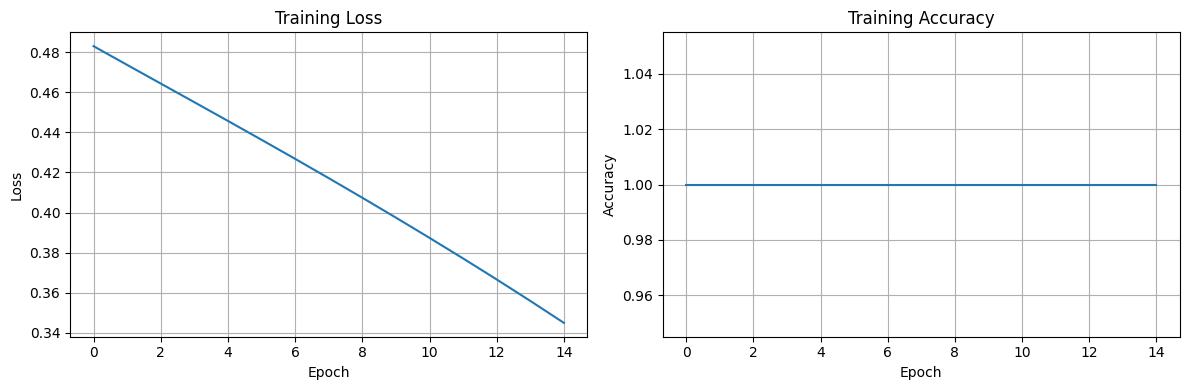

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accuracies, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()